In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import sys, os

os.environ["JAX_ENABLE_X64"] = "True"
os.environ["JAX_PLATFORM_NAME"] = "CPU"
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np
from jax import numpy as jnp, jit, jacobian

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
from pmpc.scp_mpc import solve
from pmpc import Problem


# Linear dynamics example

In [36]:
p = Problem(N=20, xdim=4, udim=2)
A = np.random.randn(p.xdim, p.xdim) + 0.4 * np.eye(p.xdim)
A = np.tile(A, (p.N, 1, 1))
B = np.tile(np.array([[0.0, 0.0, 0.0, 0.3], [0.0, 0.0, 0.3, 0.0]]).T, (p.N, 1, 1))


def linear_dynamics_f_fx_fu_fn(x, u, p=None):
    xp = (A @ x[..., None])[..., 0] + (B @ u[..., None])[..., 0]
    return xp, A, B


In [37]:
p.x0 = np.random.randn(p.xdim)
p.f_fx_fu_fn = linear_dynamics_f_fx_fu_fn
p.reg_x, p.reg_u = 1e-3, 1e-3
p.max_it = 1

X, U, _ = solve(**p)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  2.110e-03 |  1.507e-01 |  2.307e+00 |  1.000e-03 |  1.000e-03 |
+------+------------+------------+------------+------------+------------+
################################################################################
Bad solution found, the solution is approximate to a residual: 2.3069e+00
################################################################################


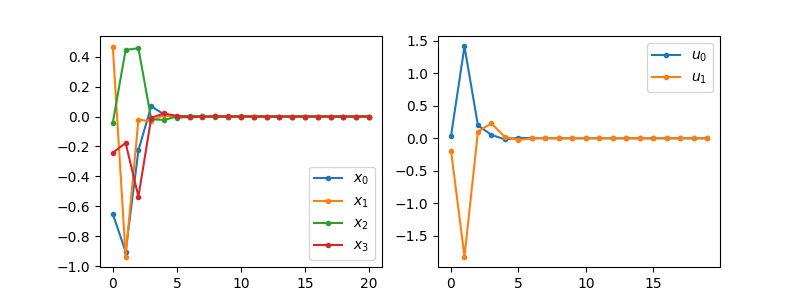

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i in range(X.shape[-1]):
    ax[0].plot(X[:, i], label=f"$x_{i}$", marker=".")
ax[0].legend()

for i in range(U.shape[-1]):
    ax[1].plot(U[:, i], label=f"$u_{i}$", marker=".")
ax[1].legend()
plt.show()

# Nonlinear dynamics and cost example

In [39]:
def car(x, u, p):
    """
    unicycle car dynamics, 4 states, 2 actions
    x1: position x
    x2: position y
    x3: speed (local frame)
    x4: orientation angle

    u1: acceleration
    u2: turning speed (independent of velocity)
    """
    assert x.shape[-1] == 4 and u.shape[-1] == 2
    v_scale, w_scale, T = p[..., 0], p[..., 1], p[..., 2]
    eps = 1e-6
    u1, u2 = v_scale * u[..., 0], w_scale * -u[..., 1]
    u1 = u1 + jnp.where(u1 >= 0.0, eps, -eps)
    u2 = u2 + jnp.where(u2 >= 0.0, eps, -eps)

    x0, y0, v0, th0 = x[..., 0], x[..., 1], x[..., 2], x[..., 3]
    xp1 = (
        x0
        + (
            u2 * jnp.sin(T * u2 + th0) * v0
            + T * u1 * u2 * jnp.sin(T * u2 + th0)
            + u1 * jnp.cos(T * u2 + th0)
        )
        / u2**2
        - (jnp.sin(th0) * u2 * v0 + jnp.cos(th0) * u1) / u2**2
    )
    xp2 = (
        y0
        - (
            u2 * jnp.cos(T * u2 + th0) * v0
            - u1 * jnp.sin(T * u2 + th0)
            + T * u1 * u2 * jnp.cos(T * u2 + th0)
        )
        / u2**2
        + (jnp.cos(th0) * u2 * v0 - jnp.sin(th0) * u1) / u2**2
    )
    xp3 = v0 + T * u1
    xp4 = T * u2 + th0
    xp = jnp.stack([xp1, xp2, xp3, xp4], -1)
    return xp


def fx_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jnp.moveaxis(jacobian(lambda x: jnp.sum(car(x, u, p), sum_dims))(x), 0, -2)


def fu_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jnp.moveaxis(jacobian(lambda u: jnp.sum(car(x, u, p), sum_dims))(u), 0, -2)


@jit
def f_fx_fu_fn(x, u, p=None):
    if p is None:
        p = jnp.array([1.0, 1.0, 0.3])
    return car(x, u, p), fx_(x, u, p), fu_(x, u, p)




In [40]:
p = Problem(N=50, xdim=4, udim=2)
p.f_fx_fu_fn = f_fx_fu_fn
p.X_ref = np.ones(p.xdim)
X_ref2 = 3 * np.ones(p.X_ref.shape)


def lin_cost_fn(x, u, problem):
    return (x - X_ref2), None

p.lin_cost_fn = lin_cost_fn
p.Q = np.concatenate([p.Q[:-1, ...], 1e2 * p.Q[-1:, ...]])
u_lim = 1e0
p.u_l = -u_lim * np.ones(p.udim)
p.u_u = u_lim * np.ones(p.udim)
p.max_it = 100
p.slew_rate = 1e0


In [41]:
X, U, _ = solve(**p)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  1.181e+00 |  5.635e+00 |  2.830e+00 |  1.000e+00 |  1.000e+00 |
| 0002 |  1.187e+00 |  2.706e+00 |  1.930e+00 |  1.000e+00 |  1.000e+00 |
| 0003 |  1.193e+00 |  3.217e+00 |  5.911e-01 |  1.000e+00 |  1.000e+00 |
| 0004 |  1.200e+00 |  3.116e+00 |  6.626e-01 |  1.000e+00 |  1.000e+00 |
| 0005 |  1.206e+00 |  3.312e+00 |  4.363e-01 |  1.000e+00 |  1.000e+00 |
| 0006 |  1.212e+00 |  3.341e+00 |  1.863e-01 |  1.000e+00 |  1.000e+00 |
| 0007 |  1.218e+00 |  3.381e+00 |  1.534e-01 |  1.000e+00 |  1.000e+00 |
| 0008 |  1.224e+00 |  3.423e+00 |  1.537e-01 |  1.000e+00 |  1.000e+00 |
| 0009 |  1.230e+00 |  3.466e+00 |  1.318e-01 |  1.000e+00 |  1.000e+00 |
| 0010 |  1.236e+00 |  3.510e+00 |  1.236e-01 |  1.000e+00 |  1.000e+00 |
| 0011 |  1.243e+00 |  3.551e+00 |  1.

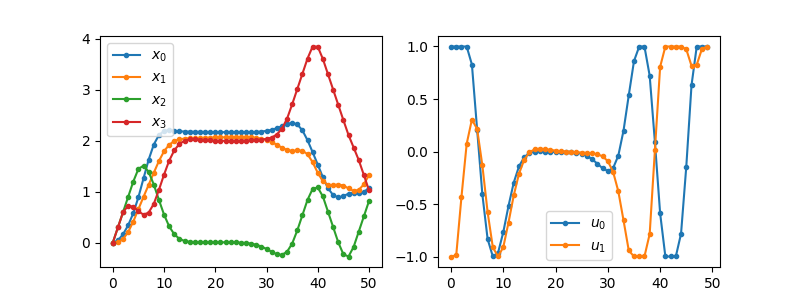

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i in range(X.shape[-1]):
    ax[0].plot(X[:, i], label=f"$x_{i}$", marker=".")
ax[0].legend()

for i in range(U.shape[-1]):
    ax[1].plot(U[:, i], label=f"$u_{i}$", marker=".")
ax[1].legend()
plt.show()